# Pairtools benchmarking

Welcome to pairtools benchmarking.

We will test performance of different software for mapping Hi-C and Hi-C-like methods:

- bwa mem and pairtools

- bwa-mem2 and pairtools

- chromap

- HiC-Pro

- Juicer

- FAN-C

- HiCExplorer


The outline:

1. [Install software](#Install-software)

2. [Download data and genome](#Download-data-and-genome)

3. [Run](#Run)

4. [Visualize benchmarks](#Visualize-benchmarks)

## Install software

We will use separate conda environments to install different utilities. Each utility will have its own environment and peth to the binaries.

In [ ]:
%%bash
mkdir ./soft

In [ ]:
# Consider adding: https://hicexplorer.readthedocs.io/en/latest/content/tools/hicBuildMatrix.html#hicbuildmatrix
### HiCExplorer

# conda install hicexplorer -c bioconda -c conda-forge

# hicBuildMatrix

### pairtools

#### pairtools v 0.3.0

In [ ]:
%%bash
conda create -y --prefix soft/pairtools0.3.0 python=3.9 pip
conda activate soft/pairtools0.3.0
conda install -y -c conda-forge -c bioconda "pairtools=0.3.0"
conda install -y -c bioconda "bwa>=0.7.17"

#### pairtools v 1.0.0

In [ ]:
%%bash
conda create -y --prefix soft/pairtools1.0.0 python=3.9 pip
conda activate soft/pairtools1.0.0
pip install cython
pip install git+https://github.com/open2c/pairtools.git@pre0.4.0 
conda install -y -c bioconda "bwa>=0.7.17"

#### Install bwa-mem2
[bwa-mem2](https://github.com/bwa-mem2/bwa-mem2) has significantly improved performance while having the same results. 

In [ ]:
%%bash 
conda activate soft/pairtools1.0.0

# bwa-mem2: compile from source (not recommended for general users)

# Get the source
git clone --recursive https://github.com/bwa-mem2/bwa-mem2 soft/bwa-mem2
cd soft/bwa-mem2

# Compile
make

# Exit compilation folder
cd ../../

### chromap

In [ ]:
%%bash
conda create -y --prefix soft/chromap
conda activate soft/chromap
conda install -y -c bioconda -c conda-forge chromap

### HiC-Pro

[HiC-Pro](https://github.com/nservant/HiC-Pro) is a popular software for Hi-C mapping, its now part of nf-core Hi-C pipeline, supports both fragment-based analysis of Hi-C and fragement-free analysis of DNase-based Hi-C.

In [ ]:
%%bash
git clone https://github.com/nservant/HiC-Pro.git soft/HiC-Pro_env/HiC-Pro
conda env create -f soft/HiC-Pro/environment.yml -p soft/HiC-Pro_env
### Working environment will be soft/HiC-Pro_env

conda activate soft/HiC-Pro_env

# Install dependencies
conda install -y -c bioconda bowtie2 samtools pysam numpy scipy bx-python
conda install -y -c r r r-rcolorbrewer r-ggplot2

# Copy prepared config:
cp configs/config-hicpro_install.txt soft/HiC-Pro_env/HiC-Pro/config-install.txt

# Configure and install:
cd soft/HiC-Pro_env/HiC-Pro
make configure
make install

cd ../../../

# Retain only data processing steps with no creating of maps:
sed -i "s/all : init mapping proc_hic merge_persample hic_qc build_raw_maps ice_norm/all : init mapping proc_hic merge_persample #hic_qc build_raw_maps ice_norm/" soft/HiC-Pro_env/HiC-Pro/scripts/Makefile

In [ ]:
%%bash
# Note that the configs should be adjusted for your system:
cp configs/config-hicpro_install.txt soft/HiC-Pro_env/HiC-Pro/config-install.txt
cp configs/config-hicpro.txt soft/HiC-Pro_env/HiC-Pro/config-hicpro.txt

### FAN-C

In [ ]:
%%bash
conda create -y --prefix soft/fanc python=3.9 pip hdf5
conda activate soft/fanc
pip install fanc
conda install -y -c bioconda samtools

### Juicer

In [ ]:
%%bash

conda create -y --prefix soft/juicer
conda activate soft/juicer

conda install -y -c bioconda bwa java-jdk
conda install -y -c conda-forge coreutils

# Download the recommended stable version:
wget https://github.com/aidenlab/juicer/archive/refs/tags/1.6.zip
unzip 1.6.zip
rm 1.6.zip
mv juicer-1.6 soft/juicer-1.6

# Download compile jar files of the stable  version:
wget http://hicfiles.tc4ga.com.s3.amazonaws.com/public/juicer/juicer_tools.1.6.2_jcuda.0.7.5.jar
mv juicer_tools.1.6.2_jcuda.0.7.5.jar soft/juicer-1.6/CPU/scripts/common/juicer_tools.jar

# Copy the scripts to some accessible location:
mkdir -p soft/juicer-1.6/CPU/scripts/
cp -r soft/juicer-1.6/CPU/[^s]* soft/juicer-1.6/CPU/scripts/

### HiCExplorer

In [ ]:
conda create -y --prefix soft/hicexplorer python=3.9
conda activate soft/hicexplorer
conda install -y -c bioconda hicexplorer bwa

## Download data and genome

In [ ]:
mkdir data

### Download raw data

Test data from Rao et al. 2017, 1 mln pairs: 

In [ ]:
fastq-dump -O data --gzip --split-files SRR6107789 --minSpotId 0 --maxSpotId 1000000

In [ ]:
# Put the data in accessible folder for juicer: 
mkdir -p data/4juicer/fastq/
mkdir -p data/4juicer/splits/
cp data/SRR6107789_1.fastq.gz data/4juicer/fastq/SRR6107789_R1.fastq.gz
cp data/SRR6107789_2.fastq.gz data/4juicer/fastq/SRR6107789_R2.fastq.gz
cp data/4juicer/fastq/* data/4juicer/splits/

In [ ]:
# Put the data in accessible folder for HiC-Pro:
mkdir -p soft/HiC-Pro_env/HiC-Pro/rawdata/sample1
cp data/S*fastq.gz soft/HiC-Pro_env/HiC-Pro/rawdata/sample1/

### Install genome

#### Genomepy installation
will install fasta, bwa and bowtie2 indexes:

In [ ]:
# Activate bwa plugin for genomepy:
! genomepy plugin enable bwa bowtie2

In [ ]:
# Install hg38 genome by genomepy:
! genomepy install hg38 -g data/

In [ ]:
# Restrict the genome:
! cooler digest data/hg38/hg38.fa.sizes data/hg38/hg38.fa DpnII -o data/hg38/hg38.DpnII.bed

#### Build genome index: bwa-mem2

In [ ]:
%%bash 
mkdir data/hg38/index/bwa-mem2/
soft/bwa-mem2/bwa-mem2 index -p data/hg38/index/bwa-mem2/hg38 data/hg38/hg38.fa

#### Build genome index: chromap

In [ ]:
%%bash 
mkdir data/hg38/index/chromap
chromap -i -r data/hg38/hg38.fa -o data/hg38/index/chromap/hg38

## Run

The banchmarking is usually cumbersome, but it can be simplified by snakemake. We provide a Snakemake pipeline that will allow you to benchmark different approaches.

The output of snakemake will consist of resulting Hi-C pairs/maps in `output` folder and benchmarking files in `benchmarks` folder. 
The file names have the information on parameters in their names:



In [ ]:
# Running 
snakemake --cores 10

In [ ]:
# Cleanup
rm output/*; rm benchmarks/*

## Manual run

You may also run them to test individual steps of the pipeline.

### pairtools

In [ ]:
soft/bwa-mem2/bwa-mem2 mem -t 5 -SP data/hg38/index/bwa-mem2/hg38 data/SRR6107789_1.fastq.gz data/SRR6107789_2.fastq.gz | \
    soft/pairtools1.0.0/bin/pairtools parse --nproc-in 5 --nproc-out 5 --drop-sam --drop-seq -c data/hg38/hg38.fa.sizes | \
    soft/pairtools1.0.0/bin/pairtools sort --nproc 5 | \
    soft/pairtools1.0.0/bin/pairtools dedup -p 5 --backend cython \
    -o output/result.pairtools.pairs

### chromap

In [ ]:
soft/chromap/bin/chromap --preset hic --low-mem \
    -t 5 -x data/hg38/index/chromap/hg38 -r data/hg38/hg38.fa \
    -1 data/SRR6107789_1.fastq.gz -2 data/SRR6107789_2.fastq.gz -o output/result.chromap.pairs

### HiC-Pro

In [ ]:
cd soft/HiC-Pro_env/HiC-Pro
bin/HiC-Pro -i rawdata/ -o output -c config-hicpro.txt

cd ../../../

### FAN-C
Based on [CLI tutorial](https://fan-c.readthedocs.io/en/latest/fanc-executable/fanc-generate-hic/fanc_modular_steps.html):

In [ ]:
fanc map -t 5 data/SRR6107789_1.fastq.gz data/hg38/index/bwa/hg38.fa output/fanc-output_1.bam
fanc map -t 5 data/SRR6107789_2.fastq.gz data/hg38/index/bwa/hg38.fa output/fanc-output_2.bam
samtools sort -@ 5 -n output/fanc-output_1.bam -o output/fanc-output_1.sorted.bam
samtools sort -@ 5 -n output/fanc-output_2.bam -o output/fanc-output_2.sorted.bam
fanc pairs output/fanc-output_1.sorted.bam output/fanc-output_2.sorted.bam output/fanc-output.pairs -g data/hg38/hg38.DpnII.bed

### Juicer

In [ ]:
soft/juicer-1.6/CPU/juicer.sh -g hg38 -d data/4juicer/ -s DpnII -S early -p data/hg38/hg38.fa.sizes -y data/hg38/hg38.DpnII.bed -z data/hg38/index/bwa/hg38.fa -t 5 -D soft/juicer-1.6/CPU

### HiCExplorer
Based on the example: https://hicexplorer.readthedocs.io/en/latest/content/example_usage.html

In [ ]:
hicBuildMatrix --samFiles \
    <(bwa mem -t 4 -A1 -B4 -E50 -L0 data/hg38/index/bwa/hg38.fa data/SRR6107789_1.fastq.gz | samtools view -Shb -) \
    <(bwa mem -t 4 -A1 -B4 -E50 -L0 data/hg38/index/bwa/hg38.fa data/SRR6107789_2.fastq.gz | samtools view -Shb -) \
     --restrictionSequence GATC \
     --danglingSequence GATC \
     --restrictionCutFile data/hg38/hg38.DpnII.bed \
     --threads 4 \
     --inputBufferSize 100000 \
     --QCfolder hicexplorer_tmp \
     -o hicexplorer_output.cool

## Visualize benchmarks

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import glob

In [4]:
files = glob.glob("benchmarks/*")

In [6]:
def get_params(filename):
    split = filename.split('.')
    util= split[1]
    regime = split[2]
    memory = split[3]
    ncores = int(split[4])
    
    return util, regime, memory, ncores

timings = []
for f in files:
    t = pd.read_table(f)
    t[['util', 'regime', 'memory', 'ncores']] = get_params(f)
    timings.append(t)
timings = pd.concat(timings)

In [7]:
timings.head()

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,util,regime,memory,ncores
0,2232.2865,0:37:12,5496.66,8171.81,5424.34,5429.77,12137.59,0.02,71.36,1593.63,pairtools03,sklearn,low,1
1,1600.8423,0:26:40,5449.21,8171.81,5443.50,5444.03,19172.39,39.25,83.87,1356.28,pairtools03,sklearn,low,1
2,1439.1596,0:23:59,5446.20,8171.81,5444.19,5444.87,27448.73,84.00,84.35,43.03,pairtools03,sklearn,low,1
3,1045.3655,0:17:25,5574.15,8171.81,5512.73,5517.64,27467.57,117.71,101.11,1095.38,pairtools03,sklearn,low,1
4,1031.9171,0:17:11,5574.22,8171.81,5512.79,5517.93,27467.58,156.94,102.40,1106.47,pairtools03,sklearn,low,1


In [23]:
df = timings.sort_values(['ncores', 'util', 'regime', 'memory'])
df.loc[:, "method"] = df.apply(lambda x: f'{x.util}.{x.regime}', axis=1)

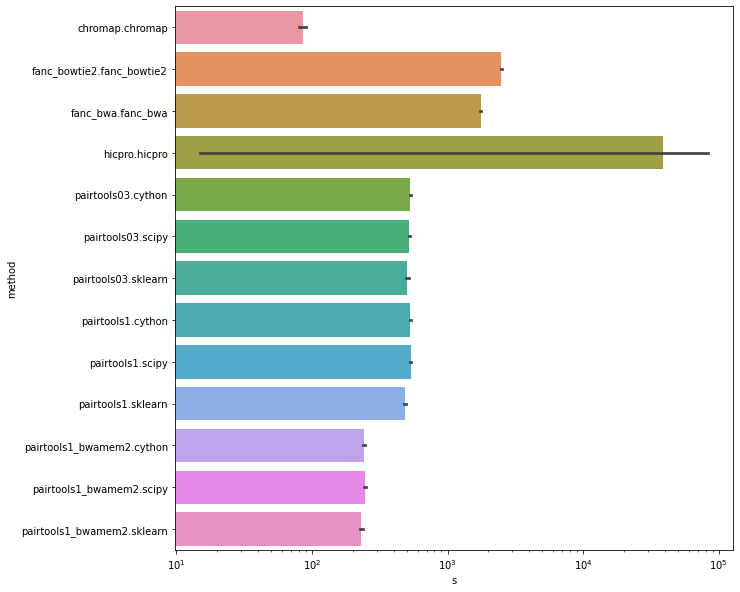

In [30]:
plt.figure(figsize=[10,10])
ax = sns.barplot(x="s", y="method", data=df.query('ncores==2'), orient='h')
plt.xscale('log')

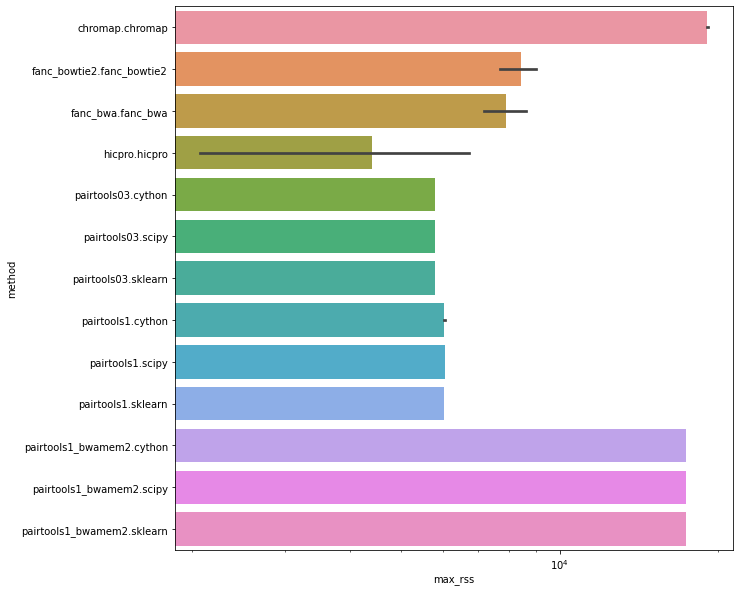

In [31]:
plt.figure(figsize=[10,10])
ax = sns.barplot(x="max_rss", y="method", data=df.query('ncores==2'), orient='h')
plt.xscale('log')